In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

In [ ]:
if IN_COLAB:
  # Uninstall tensorflow first
  !pip uninstall tensorflow -y
  # Install tensorflow-gpu (stable version)
  !pip install tensorflow-gpu  # stable

  import tensorflow as tf
  # Check version
  print(tf.__version__)

  from tensorflow.python.client import device_lib
  device_lib.list_local_devices()

2.3.1


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from matplotlib import pyplot as plt

In [ ]:
%matplotlib inline

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
def get_filepath(foldername,filename):
  
  if IN_COLAB:
      from google.colab import drive
      drive.mount('/content/drive')
      data_path = 'drive/My Drive/datasets/{foldername}/{filename}'
      source_path = Path.cwd()
      return source_path.joinpath(data_path.format(foldername=foldername,filename=filename))
  else:
      data_path='{filename}'
      source_path =Path.cwd().joinpath('datasource')
      return source_path.joinpath(data_path.format(filename=filename))

In [ ]:



foldername = 'gender'
train_file = get_filepath(foldername,'train.csv')
test_file  = get_filepath(foldername,'test.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_df = pd.read_csv(train_file)

In [ ]:
test_df = pd.read_csv(test_file)

In [ ]:
image_path = train_file.parent.joinpath('images')
image_path

PosixPath('/content/drive/My Drive/datasets/gender/images')

In [ ]:
train_df.head()

,image_names,class
0,11413.jpg,1
1,9863.jpg,1
2,997.jpg,0
3,5950.jpg,0
4,10454.jpg,1


In [ ]:
train_df['class'].value_counts()

1    6174
0    6022
Name: class, dtype: int64

In [ ]:
train_df['class'] = train_df['class'].map({1: 'Male', 0: 'Female'})

In [ ]:
train_df['class'].value_counts()

Male      6174
Female    6022
Name: class, dtype: int64

In [ ]:
def get_images(df):
  X = []
# iterating over each image
  for img_name in df.image_names:
      # loading the image using its name
      img = plt.imread(str(image_path)+'/'+img_name)
      # saving each image in the list
      # img = img/255
      X.append(img)
    
# converting the list of images into array
  X=np.array(X)
  return X

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255.0,validation_split =0.33,)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df, 
                                              directory=str(image_path)+'/',
                                              x_col="image_names", 
                                              y_col="class", 
                                              class_mode="binary", 
                                              target_size=(96, 96), 
                                              subset="training",
                                              batch_size =512,
                                              seed=42)

Found 8172 validated image filenames belonging to 2 classes.


In [ ]:
valid_generator = train_datagen.flow_from_dataframe(dataframe=train_df, 
                                              directory=str(image_path)+'/',
                                              x_col="image_names", 
                                              y_col="class", 
                                              class_mode="binary", 
                                              target_size=(96, 96), 
                                              subset="validation",
                                              batch_size =512,
                                              seed=42)

Found 4024 validated image filenames belonging to 2 classes.


In [ ]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size


In [ ]:
STEP_SIZE_TRAIN

15

In [ ]:
STEP_SIZE_VALID

7

In [ ]:
y = train_df['class'].values

In [ ]:
from keras.layers import Dense, InputLayer, BatchNormalization, Dropout,GlobalAveragePooling2D
from keras.models import Sequential
# importing adam optimizer from keras optimizer module 
from keras.optimizers import Adam

# train_test_split to create training and validation set
from sklearn.model_selection import train_test_split
# accuracy_score to calculate the accuracy of predictions
from sklearn.metrics import accuracy_score

In [ ]:
from keras.layers import Conv2D, Flatten
from keras.layers import MaxPool2D
from keras.optimizers import Adam

In [ ]:
# defining the model architecture

# creating a sequential model 
model = Sequential()
    
# defining input layer with 3D input of shape (224,224,3)
model.add(InputLayer(input_shape=(96, 96, 3)))

# defining the first convolutional layer with 25 filters of size (5,5)
model.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same'))
# adding maxpool layer after the convolutional layers
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))


# defining the second convolutional layer with 50 filters of size (5,5)
model.add(Conv2D(48, (3,3), activation='relu', strides=(1, 1), padding='same'))
# adding maxpool layer after the convolutional layers
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(64, (3,3), activation='relu', strides=(1, 1), padding='same'))
# adding maxpool layer after the convolutional layers
model.add(MaxPool2D(pool_size=(3,3), padding='same'))

# # defining the second convolutional layer with 50 filters of size (5,5)
model.add(Conv2D(64, (5, 5), activation='relu', strides=(1, 1), padding='same'))
# adding maxpool layer after the convolutional layers
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(128, (3, 3), activation='relu', strides=(1, 1), padding='same'))
# adding maxpool layer after the convolutional layers
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(256, (3, 3), activation='relu', strides=(1, 1), padding='same'))
model.add(GlobalAveragePooling2D())

# flattening the output from convolutional layers so that it can be forwarded to the dense layers
model.add(Flatten())

#model.add(Dense(units=512, activation='relu'))
 
#model.add(Dropout(rate=0.5))
# defining the first dense or fully connected layer with 100 neurons
model.add(Dense(units=100, activation='relu'))
model.add(BatchNormalization())
# model.add(Dropout(rate=0.5))
# defining the output layer with 1 neuron since it is a binary classification problem
model.add(Dense(units=1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 48)        13872     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        27712     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          1

In [ ]:
adam = Adam(lr=1e-4)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
X_train, X_valid, y_train, y_valid=train_test_split(train_df['image_names'],train_df['class'],test_size=0.3, random_state=42)
## Image Augmentation using Keras (ImageDataGenerator)
#from keras.preprocessing.image import ImageDataGenerator
# image_augmentation = ImageDataGenerator(rotation_range=30, width_shift_range=40, height_shift_range=40, 
#                              horizontal_flip=True, vertical_flip=True, fill_mode="nearest")
# image_augmentation.fit(X_train)
# model_history = model.fit(X_train, y_train, epochs=20, batch_size=128,validation_data=(X_valid,y_valid))

In [ ]:
from keras.callbacks import ModelCheckpoint

In [ ]:
filepath = get_filepath(foldername,filename='best_weights.hdf5')
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# defining checkpointing variable
callbacks_list = [checkpoint]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model_history = model.fit(train_generator,
                          steps_per_epoch=STEP_SIZE_TRAIN,
                          validation_data=valid_generator,
                          validation_steps=STEP_SIZE_VALID,
                          epochs=30,
                          callbacks=callbacks_list
                          )

Epoch 1/30
15/15 [==============================] - ETA: 0s - loss: 0.6704 - accuracy: 0.6174
Epoch 00001: val_accuracy improved from -inf to 0.62779, saving model to /content/drive/My Drive/datasets/gender/best_weights.hdf5
15/15 [==============================] - 22s 1s/step - loss: 0.6704 - accuracy: 0.6174 - val_loss: 0.6907 - val_accuracy: 0.6278
Epoch 2/30
15/15 [==============================] - ETA: 0s - loss: 0.5909 - accuracy: 0.7110
Epoch 00002: val_accuracy improved from 0.62779 to 0.70312, saving model to /content/drive/My Drive/datasets/gender/best_weights.hdf5
15/15 [==============================] - 21s 1s/step - loss: 0.5909 - accuracy: 0.7110 - val_loss: 0.6829 - val_accuracy: 0.7031
Epoch 3/30
15/15 [==============================] - ETA: 0s - loss: 0.4924 - accuracy: 0.7742
Epoch 00003: val_accuracy improved from 0.70312 to 0.75530, saving model to /content/drive/My Drive/datasets/gender/best_weights.hdf5
15/15 [==============================] - 21s 1s/step - loss: 

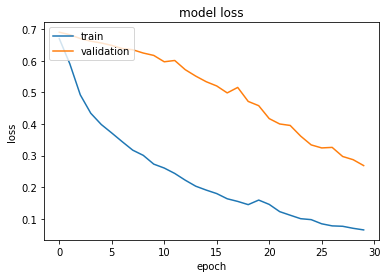

In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

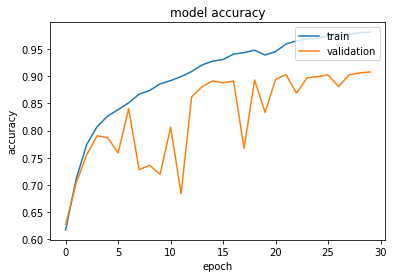

In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
model.load_weights(filepath)

In [ ]:
test_datagen = ImageDataGenerator(rescale=1/255.0,validation_split =0.33,
                                   )


In [ ]:
test_generator = test_datagen.flow_from_dataframe(dataframe=test_df, 
                                              directory=str(image_path)+'/',
                                              x_col="image_names", 
                                              y_col=None,
                                              class_mode=None, 
                                              target_size=(96, 96), 
                                              batch_size =512,
                                              shuffle=False,)
                                      

Found 5227 validated image filenames.


In [ ]:
y_pred = model.predict_classes(test_generator)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
y_pred =y_pred.flatten()

In [ ]:
test_df['class'] =y_pred

In [ ]:
test_df['class'].value_counts()

1    2731
0    2496
Name: class, dtype: int64

In [ ]:
test_df.head()

,image_names,class
0,5603.jpg,1
1,1286.jpg,1
2,9815.jpg,0
3,8865.jpg,0
4,9306.jpg,1


In [ ]:
submission_file = get_filepath(foldername,filename='submission_DEC012020_0401.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
test_df.to_csv(submission_file,index=False)

In [ ]:
model.save(get_filepath(foldername,filename='model_DEC012020_04.hdf5'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
